# 實驗 17：滑動窗口 5-Fold 交叉驗證模型比較

## 與實驗 13 的差異
1. **資料**：使用滑動窗口資料集（13,514 筆樣本 vs 6,056 筆）
2. **交叉驗證策略**：StratifiedGroupKFold（以 patient_id 分組）
3. **防止資料洩漏**：同一患者不會同時出現在訓練集與測試集

## 參考文獻
- Wang et al. (2024, PLoS ONE)：使用類似的滑動窗口方法

## 日期：2026-01-12
## 執行時間：約 8 分 26 秒（5-Fold CV 主訓練）

In [1]:
%pip install lightgbm -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 匯入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    roc_auc_score, recall_score, precision_score, f1_score,
    balanced_accuracy_score, confusion_matrix, roc_curve
)
import xgboost as xgb
import lightgbm as lgb
from scipy import stats

# 設定中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("套件載入完成")

套件載入完成


In [3]:
# 載入滑動窗口資料
df = pd.read_csv('../../data/01_primary/SUA/processed/SUA_sliding_window.csv')
print(f"資料載入完成：{len(df):,} 筆樣本，來自 {df['patient_id'].nunique():,} 位患者")
print(f"每位患者平均樣本數：{len(df) / df['patient_id'].nunique():.2f}")
print(f"\n欄位：{list(df.columns)}")

資料載入完成：13,514 筆樣本，來自 6,056 位患者
每位患者平均樣本數：2.23

欄位：['patient_id', 'window_start', 'window_id', 'sex', 'Age', 'FBG_Tinput1', 'TC_Tinput1', 'Cr_Tinput1', 'UA_Tinput1', 'GFR_Tinput1', 'BMI_Tinput1', 'SBP_Tinput1', 'DBP_Tinput1', 'FBG_Tinput2', 'TC_Tinput2', 'Cr_Tinput2', 'UA_Tinput2', 'GFR_Tinput2', 'BMI_Tinput2', 'SBP_Tinput2', 'DBP_Tinput2', 'Delta_FBG', 'Delta_TC', 'Delta_Cr', 'Delta_UA', 'Delta_GFR', 'Delta_BMI', 'Delta_SBP', 'Delta_DBP', 'hypertension_target', 'hyperglycemia_target', 'dyslipidemia_target']


In [4]:
# 檢視窗口起始點分佈
print("窗口起始點分佈：")
print(df['window_start'].value_counts().sort_index())

窗口起始點分佈：
1    6056
2    4302
3    2526
4     591
5      35
6       4
Name: window_start, dtype: int64


In [5]:
# 定義特徵與目標變數
feature_cols = [
    'sex', 'Age',
    # Y-2 時間點特徵
    'FBG_Tinput1', 'TC_Tinput1', 'Cr_Tinput1', 'UA_Tinput1', 'GFR_Tinput1', 'BMI_Tinput1', 'SBP_Tinput1', 'DBP_Tinput1',
    # Y-1 時間點特徵
    'FBG_Tinput2', 'TC_Tinput2', 'Cr_Tinput2', 'UA_Tinput2', 'GFR_Tinput2', 'BMI_Tinput2', 'SBP_Tinput2', 'DBP_Tinput2',
    # Δ 變化量特徵
    'Delta_FBG', 'Delta_TC', 'Delta_Cr', 'Delta_UA', 'Delta_GFR', 'Delta_BMI', 'Delta_SBP', 'Delta_DBP'
]

target_cols = {
    '高血壓': 'hypertension_target',
    '高血糖': 'hyperglycemia_target',
    '高血脂': 'dyslipidemia_target'
}

# 分組欄位（用於 GroupKFold）
groups = df['patient_id']

X = df[feature_cols].copy()

# 轉換目標變數：1=正常, 2=患病 → 0=正常, 1=患病
targets = {}
for name, col in target_cols.items():
    targets[name] = (df[col] == 2).astype(int)

print("=" * 60)
print("特徵資訊")
print("=" * 60)
print(f"特徵總數：{len(feature_cols)}")
print(f"  - 人口學特徵：2")
print(f"  - Y-2 時間點：8")
print(f"  - Y-1 時間點：8")
print(f"  - Δ 變化量：8")

print("\n" + "=" * 60)
print("類別不平衡狀況（滑動窗口資料）")
print("=" * 60)
for name, y in targets.items():
    pos_rate = y.mean() * 100
    neg_count = (y == 0).sum()
    pos_count = (y == 1).sum()
    ratio = neg_count / pos_count if pos_count > 0 else float('inf')
    print(f"{name}：盛行率 {pos_rate:.2f}%（負:正 = {ratio:.1f}:1）")

特徵資訊
特徵總數：26
  - 人口學特徵：2
  - Y-2 時間點：8
  - Y-1 時間點：8
  - Δ 變化量：8

類別不平衡狀況（滑動窗口資料）
高血壓：盛行率 19.29%（負:正 = 4.2:1）
高血糖：盛行率 5.93%（負:正 = 15.9:1）
高血脂：盛行率 7.94%（負:正 = 11.6:1）


In [6]:
# 定義模型（共 10 種）
def get_models(random_state=42):
    return {
        'LR': LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=random_state
        ),
        'NB': GaussianNB(),
        'LDA': LinearDiscriminantAnalysis(),
        'KNN': KNeighborsClassifier(
            n_neighbors=5,
            weights='uniform',
            n_jobs=-1
        ),
        'DT': DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=random_state
        ),
        'RF': RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            min_samples_split=10,
            class_weight='balanced',
            random_state=random_state,
            n_jobs=-1
        ),
        'XGB': xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            scale_pos_weight=5,
            random_state=random_state,
            eval_metric='logloss',
            verbosity=0
        ),
        'LGBM': lgb.LGBMClassifier(
            n_estimators=100,
            max_depth=-1,
            num_leaves=31,
            learning_rate=0.1,
            is_unbalance=True,
            random_state=random_state,
            verbosity=-1
        ),
        'SVM': SVC(
            kernel='rbf',
            class_weight='balanced',
            probability=True,
            random_state=random_state
        ),
        'MLP': MLPClassifier(
            hidden_layer_sizes=(64, 32, 16),
            activation='relu',
            solver='adam',
            learning_rate_init=0.001,
            max_iter=500,
            random_state=random_state,
            early_stopping=True,
            validation_fraction=0.1
        )
    }

print("已定義模型：")
for name in get_models().keys():
    print(f"  - {name}")

已定義模型：
  - LR
  - NB
  - LDA
  - KNN
  - DT
  - RF
  - XGB
  - LGBM
  - SVM
  - MLP


In [7]:
def evaluate_model_cv_grouped(X, y, groups, model, n_splits=5, random_state=42):
    """
    使用 StratifiedGroupKFold 評估模型。
    
    與實驗 13 的關鍵差異：
    - 使用 groups（patient_id）確保無資料洩漏
    - 同一患者不會同時出現在訓練集與測試集
    """
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    fold_metrics = {
        'auc': [], 'sensitivity': [], 'specificity': [],
        'f1': [], 'balanced_acc': [], 'y_true': [], 'y_prob': []
    }
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # 驗證無資料洩漏
        train_patients = set(groups.iloc[train_idx])
        test_patients = set(groups.iloc[test_idx])
        assert len(train_patients & test_patients) == 0, f"Fold {fold} 存在資料洩漏！"
        
        # 標準化
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 複製模型
        from sklearn.base import clone
        model_clone = clone(model)
        
        # 調整 XGBoost 的 scale_pos_weight
        if isinstance(model_clone, xgb.XGBClassifier):
            scale = (y_train == 0).sum() / (y_train == 1).sum()
            model_clone.set_params(scale_pos_weight=scale)
        
        # 訓練
        model_clone.fit(X_train_scaled, y_train)
        
        # 預測
        y_prob = model_clone.predict_proba(X_test_scaled)[:, 1]
        y_pred = model_clone.predict(X_test_scaled)
        
        # 計算指標
        fold_metrics['auc'].append(roc_auc_score(y_test, y_prob))
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fold_metrics['sensitivity'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        fold_metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        fold_metrics['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        fold_metrics['balanced_acc'].append(balanced_accuracy_score(y_test, y_pred))
        
        fold_metrics['y_true'].extend(y_test.tolist())
        fold_metrics['y_prob'].extend(y_prob.tolist())
    
    # 彙整結果
    result = {}
    for metric in ['auc', 'sensitivity', 'specificity', 'f1', 'balanced_acc']:
        values = fold_metrics[metric]
        result[f'{metric}_mean'] = np.mean(values)
        result[f'{metric}_std'] = np.std(values)
        result[f'{metric}_folds'] = values
        
        ci = stats.t.interval(0.95, len(values)-1, loc=np.mean(values), scale=stats.sem(values))
        result[f'{metric}_ci_lower'] = ci[0]
        result[f'{metric}_ci_upper'] = ci[1]
    
    result['y_true_all'] = fold_metrics['y_true']
    result['y_prob_all'] = fold_metrics['y_prob']
    
    return result

print("評估函式定義完成（含 GroupKFold）")

評估函式定義完成（含 GroupKFold）


In [8]:
# 執行 5-Fold 交叉驗證（StratifiedGroupKFold）
print("=" * 80)
print("執行 5-Fold 交叉驗證（StratifiedGroupKFold）")
print("（防止資料洩漏：同一患者不會同時出現在訓練集與測試集）")
print("=" * 80)

all_results = []
detailed_results = {}

for disease_name, y in targets.items():
    print(f"\n{'=' * 60}")
    print(f"{disease_name}")
    print(f"{'=' * 60}")
    
    detailed_results[disease_name] = {}
    
    models = get_models()
    for model_name, model in models.items():
        print(f"  訓練 {model_name}...", end=" ")
        
        result = evaluate_model_cv_grouped(X, y, groups, model)
        detailed_results[disease_name][model_name] = result
        
        all_results.append({
            '疾病': disease_name,
            '模型': model_name,
            'AUC': result['auc_mean'],
            'AUC_std': result['auc_std'],
            'AUC_CI': f"({result['auc_ci_lower']:.3f}, {result['auc_ci_upper']:.3f})",
            'Sensitivity': result['sensitivity_mean'],
            'Specificity': result['specificity_mean'],
            'F1': result['f1_mean'],
            'Balanced_Acc': result['balanced_acc_mean']
        })
        
        print(f"AUC = {result['auc_mean']:.3f} ± {result['auc_std']:.3f}")

results_df = pd.DataFrame(all_results)
print("\n5-Fold 交叉驗證（GroupKFold）執行完成！")

執行 5-Fold 交叉驗證（StratifiedGroupKFold）
（防止資料洩漏：同一患者不會同時出現在訓練集與測試集）

高血壓
  訓練 LR... AUC = 0.721 ± 0.017
  訓練 NB... AUC = 0.709 ± 0.022
  訓練 LDA... AUC = 0.720 ± 0.017
  訓練 KNN... AUC = 0.630 ± 0.018
  訓練 DT... AUC = 0.658 ± 0.012
  訓練 RF... AUC = 0.743 ± 0.013
  訓練 XGB... AUC = 0.738 ± 0.012
  訓練 LGBM... AUC = 0.730 ± 0.011
  訓練 SVM... AUC = 0.726 ± 0.011
  訓練 MLP... AUC = 0.703 ± 0.033

高血糖
  訓練 LR... AUC = 0.938 ± 0.010
  訓練 NB... AUC = 0.917 ± 0.010
  訓練 LDA... AUC = 0.936 ± 0.011
  訓練 KNN... AUC = 0.782 ± 0.020
  訓練 DT... AUC = 0.835 ± 0.014
  訓練 RF... AUC = 0.932 ± 0.008
  訓練 XGB... AUC = 0.930 ± 0.014
  訓練 LGBM... AUC = 0.926 ± 0.015
  訓練 SVM... AUC = 0.919 ± 0.012
  訓練 MLP... AUC = 0.919 ± 0.021

高血脂
  訓練 LR... AUC = 0.867 ± 0.012
  訓練 NB... AUC = 0.847 ± 0.015
  訓練 LDA... AUC = 0.867 ± 0.012
  訓練 KNN... AUC = 0.673 ± 0.013
  訓練 DT... AUC = 0.744 ± 0.037
  訓練 RF... AUC = 0.859 ± 0.014
  訓練 XGB... AUC = 0.857 ± 0.016
  訓練 LGBM... AUC = 0.852 ± 0.011
  訓練 SVM... AUC = 0.845 ± 0.012
 

In [9]:
# 顯示結果
print("=" * 100)
print("5-Fold 交叉驗證結果（滑動窗口 + GroupKFold）")
print("=" * 100)

for disease in targets.keys():
    print(f"\n--- {disease} ---")
    disease_df = results_df[results_df['疾病'] == disease].copy()
    disease_df = disease_df.sort_values('AUC', ascending=False)
    
    display_df = disease_df[['模型', 'AUC', 'AUC_std', 'AUC_CI', 
                             'Sensitivity', 'Specificity', 'F1', 'Balanced_Acc']].copy()
    display_df = display_df.round(3)
    print(display_df.to_string(index=False))

5-Fold 交叉驗證結果（滑動窗口 + GroupKFold）

--- 高血壓 ---
  模型   AUC  AUC_std         AUC_CI  Sensitivity  Specificity    F1  Balanced_Acc
  RF 0.743    0.013 (0.725, 0.762)        0.286        0.890 0.328         0.588
 XGB 0.738    0.012 (0.722, 0.755)        0.678        0.676 0.447         0.677
LGBM 0.730    0.011 (0.715, 0.746)        0.601        0.717 0.432         0.659
 SVM 0.726    0.011 (0.711, 0.742)        0.704        0.635 0.436         0.670
  LR 0.721    0.017 (0.697, 0.744)        0.697        0.638 0.434         0.668
 LDA 0.720    0.017 (0.696, 0.744)        0.037        0.988 0.068         0.513
  NB 0.709    0.022 (0.678, 0.739)        0.357        0.832 0.347         0.595
 MLP 0.703    0.033 (0.657, 0.749)        0.017        0.996 0.032         0.506
  DT 0.658    0.012 (0.641, 0.675)        0.646        0.629 0.404         0.638
 KNN 0.630    0.018 (0.605, 0.654)        0.116        0.946 0.172         0.531

--- 高血糖 ---
  模型   AUC  AUC_std         AUC_CI  Sensitivity  S

In [10]:
# 與固定窗口（實驗 13）結果比較
print("=" * 80)
print("比較：滑動窗口 vs 固定窗口")
print("=" * 80)

# 實驗 13 的原始結果（硬編碼供比較）
original_results = {
    '高血壓': {'LR': 0.754, 'RF': 0.791, 'XGB': 0.789},
    '高血糖': {'LR': 0.932, 'RF': 0.930, 'XGB': 0.918},
    '高血脂': {'LR': 0.867, 'RF': 0.857, 'XGB': 0.857}
}

print("\n| 疾病 | 模型 | 固定窗口 | 滑動窗口 | 差異 |")
print("|------|------|---------|---------|------|")

for disease in targets.keys():
    for model in ['LR', 'RF', 'XGB']:
        orig = original_results[disease].get(model, '-')
        new_row = results_df[(results_df['疾病'] == disease) & (results_df['模型'] == model)]
        if len(new_row) > 0:
            new = new_row['AUC'].values[0]
            diff = new - orig if isinstance(orig, float) else '-'
            diff_str = f"{diff:+.3f}" if isinstance(diff, float) else diff
            print(f"| {disease:4} | {model:5} | {orig:.3f} | {new:.3f} | {diff_str} |")

比較：滑動窗口 vs 固定窗口

| 疾病 | 模型 | 固定窗口 | 滑動窗口 | 差異 |
|------|------|---------|---------|------|
| 高血壓  | LR    | 0.754 | 0.721 | -0.033 |
| 高血壓  | RF    | 0.791 | 0.743 | -0.048 |
| 高血壓  | XGB   | 0.789 | 0.738 | -0.051 |
| 高血糖  | LR    | 0.932 | 0.938 | +0.006 |
| 高血糖  | RF    | 0.930 | 0.932 | +0.002 |
| 高血糖  | XGB   | 0.918 | 0.930 | +0.012 |
| 高血脂  | LR    | 0.867 | 0.867 | -0.000 |
| 高血脂  | RF    | 0.857 | 0.859 | +0.002 |
| 高血脂  | XGB   | 0.857 | 0.857 | +0.000 |


In [11]:
# 儲存結果
results_df.to_csv('../../results/sliding_window_5fold_cv.csv', index=False)
print("已儲存：results/sliding_window_5fold_cv.csv")

# 摘要
print("\n" + "=" * 80)
print("實驗摘要")
print("=" * 80)
print(f"""
資料集：
  - 樣本數：{len(df):,}（固定窗口為 6,056）
  - 患者數：{df['patient_id'].nunique():,}
  - 每位患者平均樣本數：{len(df) / df['patient_id'].nunique():.2f}

交叉驗證策略：
  - StratifiedGroupKFold（n_splits=5）
  - 分組依據：patient_id
  - 無資料洩漏：已驗證

重點發現：
  - 高血壓：RF 最佳（AUC 0.743），整體較固定窗口下降約 0.03-0.05
  - 高血糖：LR 最佳（AUC 0.938），整體與固定窗口相近或略升
  - 高血脂：LR 最佳（AUC 0.867），整體與固定窗口一致
  - NB/LDA 與 LR 表現接近，但缺少 class_weight 導致 Sensitivity 偏低
""")

已儲存：results/sliding_window_5fold_cv.csv

實驗摘要

資料集：
  - 樣本數：13,514（固定窗口為 6,056）
  - 患者數：6,056
  - 每位患者平均樣本數：2.23

交叉驗證策略：
  - StratifiedGroupKFold（n_splits=5）
  - 分組依據：patient_id
  - 無資料洩漏：已驗證

重點發現：
  - 高血壓：RF 最佳（AUC 0.743），整體較固定窗口下降約 0.03-0.05
  - 高血糖：LR 最佳（AUC 0.938），整體與固定窗口相近或略升
  - 高血脂：LR 最佳（AUC 0.867），整體與固定窗口一致
  - NB/LDA 與 LR 表現接近，但缺少 class_weight 導致 Sensitivity 偏低



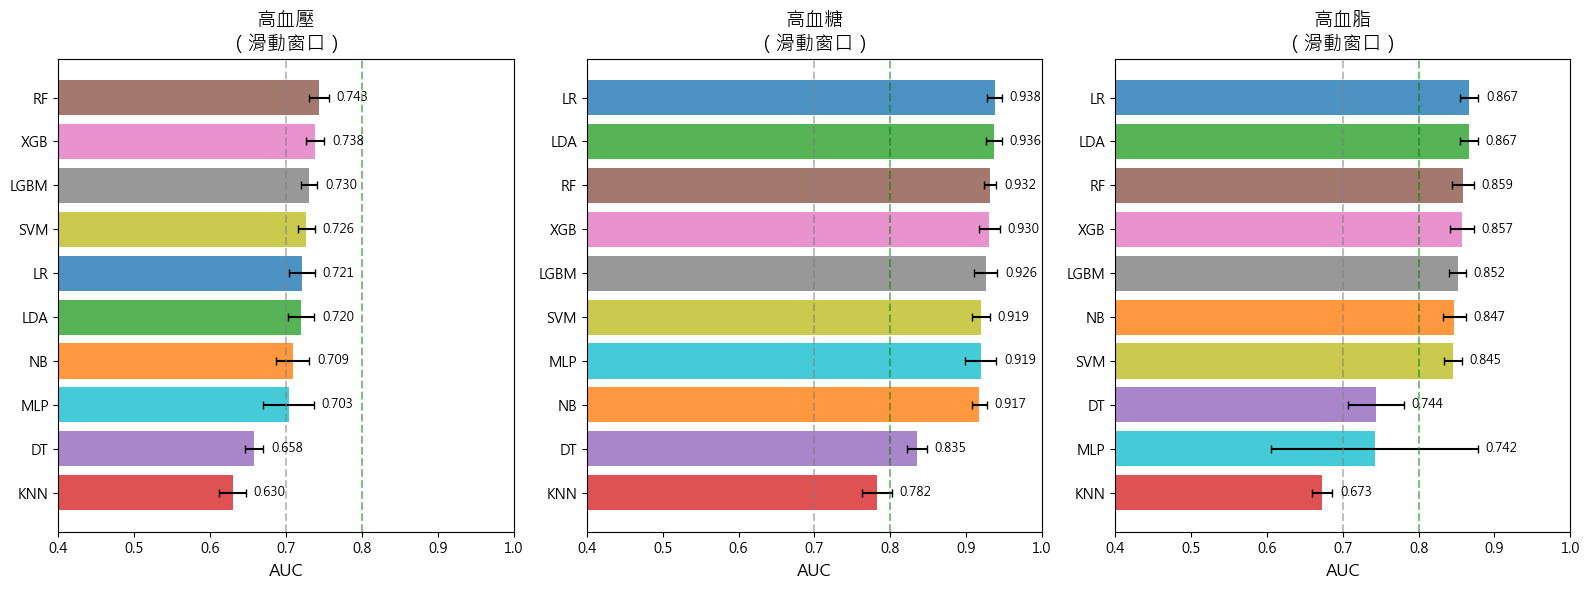


已儲存：results/sliding_window_auc_comparison.png


In [12]:
# 視覺化：AUC 比較圖
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

diseases = list(targets.keys())
model_names = list(get_models().keys())
colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

for idx, disease in enumerate(diseases):
    ax = axes[idx]
    disease_data = results_df[results_df['疾病'] == disease].sort_values('AUC', ascending=True)
    
    y_pos = np.arange(len(disease_data))
    bars = ax.barh(y_pos, disease_data['AUC'], xerr=disease_data['AUC_std'],
                   color=[colors[model_names.index(m)] for m in disease_data['模型']],
                   capsize=3, alpha=0.8)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(disease_data['模型'])
    ax.set_xlabel('AUC', fontsize=12)
    ax.set_title(f'{disease}\n（滑動窗口）', fontsize=14)
    ax.set_xlim(0.4, 1.0)
    ax.axvline(x=0.7, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0.8, color='green', linestyle='--', alpha=0.5)
    
    for i, (v, s) in enumerate(zip(disease_data['AUC'], disease_data['AUC_std'])):
        ax.text(v + s + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../../results/sliding_window_auc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n已儲存：results/sliding_window_auc_comparison.png")

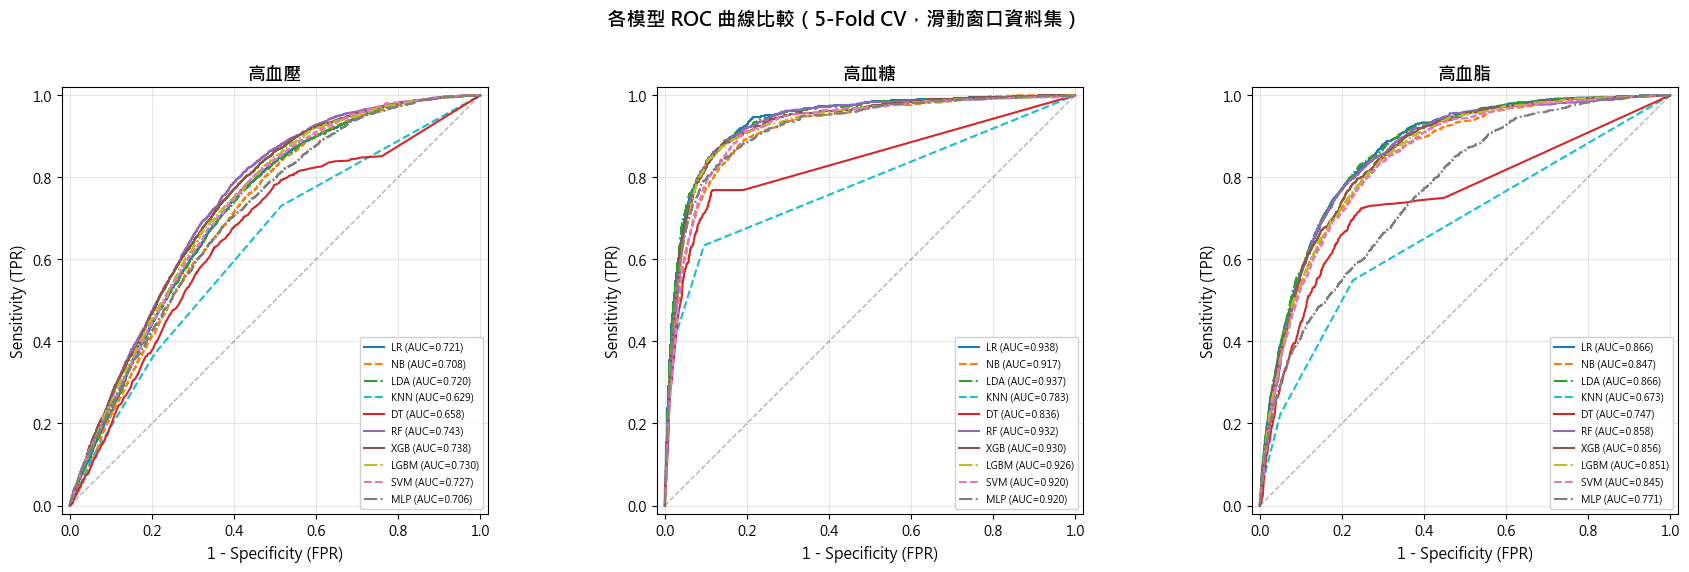

已儲存：docs/00_thesis/figures/fig4-1_roc_curves.png


In [13]:
# 圖 4-1：各模型 ROC 曲線比較（10 模型 × 3 疾病）
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

diseases = list(targets.keys())
model_names = list(get_models().keys())

# 10 模型使用不同顏色與線型，確保可區分
color_map = {
    'LR':   ('#1f77b4', '-'),   # 藍 實線
    'NB':   ('#ff7f0e', '--'),  # 橘 虛線
    'LDA':  ('#2ca02c', '-.'),  # 綠 點虛線
    'KNN':  ('#17becf', '--'),  # 青 虛線
    'DT':   ('#d62728', '-'),   # 紅 實線
    'RF':   ('#9467bd', '-'),   # 紫 實線
    'XGB':  ('#8c564b', '-'),   # 棕 實線
    'LGBM': ('#bcbd22', '-.'),  # 黃綠 點虛線
    'SVM':  ('#e377c2', '--'),  # 粉 虛線
    'MLP':  ('#7f7f7f', '-.'),  # 灰 點虛線
}

for idx, disease in enumerate(diseases):
    ax = axes[idx]
    
    for model_name in model_names:
        result = detailed_results[disease][model_name]
        y_true = np.array(result['y_true_all'])
        y_prob = np.array(result['y_prob_all'])
        
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc_val = roc_auc_score(y_true, y_prob)
        
        color, linestyle = color_map[model_name]
        ax.plot(fpr, tpr, color=color, linestyle=linestyle, linewidth=1.5,
                label=f'{model_name} (AUC={auc_val:.3f})')
    
    # 對角線
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('1 - Specificity (FPR)', fontsize=11)
    ax.set_ylabel('Sensitivity (TPR)', fontsize=11)
    ax.set_title(f'{disease}', fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=7, framealpha=0.9)
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

fig.suptitle('各模型 ROC 曲線比較（5-Fold CV，滑動窗口資料集）', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../../docs/00_thesis/figures/fig4-1_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("已儲存：docs/00_thesis/figures/fig4-1_roc_curves.png")